In [33]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, numpy as np, pandas as pd, PyDSTool as dst, time, odespy
from PyDSTool import args
sn.set_context('notebook')

# Solving Ordinary Differential Equations

## 1. Background

The very basic water balance models I've coded previously involve ODEs with simple analytical solutions. In future I'd like to work with more complex systems of equations where exact solutions are either impossible or beyond my ability to integrate. These notes document my experiments so far with various numerical solvers.

## 2. The model

As a test problem, I'm going to try to build a simple hydrological model consisting of just two "**linear reservoirs**" (i.e. buckets). This system has a straightforward analytical solution, so I should be able to test whether I'm using the numerical solvers correctly.

<img src="https://drive.google.com/uc?export=&id=0BximeC_RweaeaHNhNUYwZjFWaXc" alt="Two bucket model" height="400" width=400> 

The **Hydrologicall Effective Rainfall**, $H$, is estimated as $(P - \alpha E)$, where $P$ is precipitation, $E$ is **potential evapotranspiration** and $\alpha$ is a "correction factor" to convert potential to **actual** evapotranspiration. For the toy example here I'm going to assume $\alpha = 0.75$, although in reality it might be estimated from e.g. land cover information.

The soil bucket receives an input flow of $H$, and the outflow from the bucket, $S$, is assumed to be directly proportional to the volume of water in the reservoir, $V_s$. The constant of proportionality is conventionally expressed as $\frac{1}{\tau_s}$, where $\tau_s$ is the “**residence time**” of the bucket. For the first bucket:

$$\frac{dV_s}{dt} = (H – S) \qquad and \qquad S = \frac{V_s}{\tau_s}$$

These expressions can be combined to give

$$\frac{dS}{dt} = \frac{(H – S)}{\tau_s}$$

A fraction of the water, $\beta$, leaving the first bucket enters the second bucket. The flow rate from the second bucket is denoted $G$ and, in the same way, the rate of change of $G$ is given by:

$$\frac{dG}{dt} = \frac{(\beta S - G)}{\tau_g}$$

## 3. Aims

I want to use numerical methods to:

  1. Calculate how $S$ and $G$ vary with time. <br><br>
  2. Calculate the total volume of water draining via the $S$ pathway (denoted $D_s$) and via the $G$ pathway (denoted $D_g$) over the course of the simulation. $D_s$ and $D_g$ are simply the integrals of $S$ and $G$ respectively:

$$\frac{dD_s}{dt} = (1 - \beta) S \qquad and \qquad \frac{dD_g}{dt} = G$$

## 4. Input data

To begin with, I'm just interested in solving the equations for a **single time step** i.e. given some initial conditions and a constant value for $H$, how does the system evolve? Eventually, though, I want to extend this to consider what options are avaialble when $H$ is a **discrete time series** with daily resolution. For this, I'll use some real data from a small study catchment in NE Scotland.

In [34]:
alpha = 0.75

# Download Tarland data
data_url = r'https://drive.google.com/uc?export=&id=0BximeC_RweaecHNIZF9GMHkwaWc'
met_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col=0)
del met_df['Q_Cumecs']

# Linear interpolation of any missing values
met_df.interpolate(method='linear', inplace=True) 

# Calculate HER
met_df['HER_mm'] = met_df['Rainfall_mm'] - alpha*met_df['PET_mm']

# Check there are no missing values
assert met_df.isnull().sum().all() == 0

print met_df.head()

            Rainfall_mm  PET_mm  HER_mm
Date                                   
2000-01-01         0.10    0.72   -0.44
2000-01-02         1.00    0.72    0.46
2000-01-03         1.10    0.72    0.56
2000-01-04         1.38    0.72    0.84
2000-01-05         3.62    0.72    3.08


## 5. Basic approach with odespy

Before getting involved with proper **dynamical systems modelling packages** like **[PyDSTool](http://www.ni.gsu.edu/~rclewley/PyDSTool/FrontPage.html)** (see section 6), I want to explore some of the simpler options. `scipy.integrate.ode` provides some basic solvers, but the options available are limtied. An alternative is the `odespy` package, which has similar syntax to `scipy.integrate.ode` but with a much broader range of integrators. The plan is to use this to get started and then see if I can do better with PyDSTool.

## 5.1. Installing odespy

This is a bit of a faff. First, you need to have the `ming32` compiler installed and on your path. Then download the .zip archive from the [odespy repository](https://github.com/hplgit/odespy) and unzip it. Open the WinPython command prompt and `cd` to the odespy directory. Try running:

    python setup.py install

You'll probably get an error message saying something like:

    File "C:\Anaconda\lib\site-packages\numpy\distutils\fcompiler\gnu.py",
    line 333, in get_libraries
    raise NotImplementedError("Only MS compiler supported with gfortran on win64")
    NotImplementedError: Only MS compiler supported with gfortran on win64

If this happens, open the file `gnu.py` at the path given by the error message and comment out the specified line, adding a pass statement:

    else:
        #raise NotImplementedError("Only MS compiler supported with gfortran on win64")
        pass

Now try:

    python setup.py install
    
again and with a bit of luck the package should install successfully, complete with all the fancy FORTRAN solvers.


## 5.2. Single time step example

The basic appraoch to using `odespy` looks something like this:

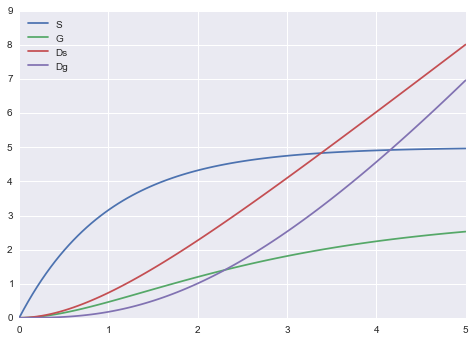

In [35]:
# Model parameters
beta = 0.6     # BFI (dimensionless)
T_s = 1.       # Soil residence time (days)
T_g = 2.       # Groundwater residence time (days)
step_len = 5   # Time step length (days)

# Initial conditions
H = 5.         # Input (mm/day)
S0 = 0.        # Soil outflow (mm/day)
G0 = 0.        # Groundwater outflow (mm/day)   

def f(y, t):
    """ Define ODE system.
    """
    # Unpack incremental values for S and G
    Si = y[0]
    Gi = y[1]

    # Model equations (see above)
    dS_dt = (H - Si)/T_s
    dG_dt = (beta*Si - Gi)/T_g
    dDs_dt = (1 - beta)*Si
    dDg_dt = Gi
    
    return [dS_dt, dG_dt, dDs_dt, dDg_dt]

# Build integrator
solver = odespy.Vode(f)  # Vode seems like a good general purpose solver
solver.set_initial_condition([S0, G0, 0, 0])  # [S, G, Ds, Dg]

# Divide step into 100 equal parts for plotting
t_i = np.linspace(0, step_len, 100)

# Solve
y, t = solver.solve(t_i)

# Plot
df = pd.DataFrame(y, columns=['S', 'G', 'Ds', 'Dg'],
                  index=t)        
df.plot()

This seems to be working OK: the soil outflow, $S$, is tending asymptotically towards $H$, and the groundwater outflow, $G$, is tending towards $\beta H$, which is as expected.

For plotting and visualisation, it's useful to evaluate many time points within the time step, as above. However, from the point of view of the model I'm really only interested in the values of $S$, $G$, $D_s$ and $D_g$ at the end of the step. I can therefore improve performance by just asking for the results that I'm interested in:

In [36]:
# Reset the solver
solver = odespy.Vode(f)
solver.set_initial_condition([S0, G0, 0, 0])  # [S, G, Ds, Dg]

# Just get results at the end of the step
t_i = [0, float(step_len)]

# Solve
y, t = solver.solve(t_i)

# Results
print 'At end of step:'
print '    S  = %.2f' % y[1, 0]
print '    G  = %.2f' % y[1, 1]
print '    Ds = %.2f' % y[1, 2]
print '    Dg = %.2f' % y[1, 3]

At end of step:
    S  = 4.97
    G  = 2.53
    Ds = 8.01
    Dg = 6.96


These results are consistent with the plot above.

### What if H is negative?

On some days, evapotranspiration exceeds precipitation, so $H < 0$. This can lead to results that are not physically meaningful:

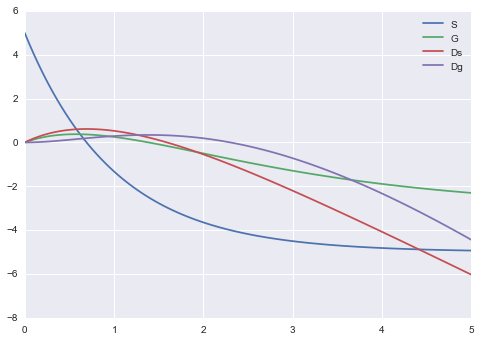

In [37]:
# New initial conditions, where soil store is part full, but H < 0
H = -5.
S0 = 5.

# Reset integrator
solver = odespy.Vode(f)
solver.set_initial_condition([S0, G0, 0, 0])  # [S, G, Ds, Dg]

# Divide step into 100 equal parts for plotting
t_i = np.linspace(0, step_len, 100)

# Solve
y, t = solver.solve(t_i)

# Plot
df = pd.DataFrame(y, columns=['S', 'G', 'Ds', 'Dg'],
                  index=t)        
df.plot()

Mathematically, this all works OK, but the negative values for $S$, $G$, $D_s$ and $D_g$ at the end of the step have no physical meaning in the model. I can think of two ways to deal with this:

  1. **Fudge it**. If the values for any of $S$, $G$, $D_s$ and $D_g$ go negative within a particular time step, I could simply **reset those values back to zero** ready for the next time step. This seems like a bad idea for a couple of reasons. Firstly, if $S$ goes negative part way through a step then $D_s$ will also start decreasing. By the end of the step, $D_s$ may still be positive, but it will nevertheless be wrong. Secondly, and perhaps more importantly, if $S$ goes negative then the computed trajectory for the water level in the *groundwater store* will be incorrect, even if the final value at the end of the step is still positive. This error will then be propagated to the next time step, creating the possibility that the groundwater store could end up evolving in completely the wrong way. Dimitri has [a paper](http://onlinelibrary.wiley.com/doi/10.1029/2009WR008894/abstract) which discusses some of these issues in more detail, it's a bit beyond me at present. **Come back and read this paper more carefully**. <br><br>
  
  2. **Consider the time step in two parts**. A better but more complicated alternative is to work out exactly **when** the soil dries out and then force a change in the behaviour of the ODE system after this point. Unfortunately this involves introduing a discontinuity which (I think) makes the equations non-integrable. To get around this, we can run the solver twice: the first time normally, up to the point where the soil dries out; we then start the solver again from this point, but with $S = H = 0$, and run until the end of the time step.
  
**Option 2** is clearly better, and it's not too difficult to code. The hard part is working out **when** the soil dries out. One way of doing this is to use the `terminate` option in `odespy`. For the simplest possible example of how to use this, consider the ODE

$$\frac{dy}{dt} = -y \qquad with \qquad y = 1 \qquad at \qquad t = 0$$
  
This problem has a particular solution of $y = e^{-t}$. We will use a `terminate` function to try to stop the solver when the threshold $y = 0.5$ is crossed. Based on the analytical solution, this should occur at $t = ln(2)$.

In [38]:
def f2(y, t):
    """ ODE to integrate.
    """   
    return -y

def terminate(y, t, step_no):
    """ Integration is terminated when this function returns True.
    """
    return y[step_no] < 0.5

# Time points for solution
t_i = [0, 1.]

# Build integrator
solver = odespy.Vode(f2)
solver.set_initial_condition(1) # y=1 at t=0

# Solve
y, t = solver.solve(t_i, terminate)

Vode terminated at t=1


In the above code, the solver prints that integration has been terminated. However, in terms of identifying the **time** of termination, it only outputs the **next time in the list of time points requested** i.e. the next time point after termination in the vector $t$, which in this case is 1.

To identify the threshold crossing more accurately, we need to divide the time step into a number of smaller segments. The more accurately we need to find the event, the more segments we will require, and this obviously has a computational cost. For example, if we are happy to identify the threshold "event" to within $\frac{1}{100}$ of a time step, we could try:



In [39]:
# Time points for solution
t_i = np.linspace(0, 1, 100)

# Build integrator
solver = odespy.Vode(f2)
solver.set_initial_condition(1) # y=1 at t=0

# Solve
y, t = solver.solve(t_i, terminate)

# Print the true value from the analytical solution
print 'Exact threshold at t=%.5F' % np.log(2)

Vode terminated at t=0.69697
Exact threshold at t=0.69315


This approach allows us to detect the threshold crossing event to within arbitrary precision. We can use this create a function for performing accurate integration across a time step, splitting the step at drying out events as necessary.

In [40]:
def f(y, t, H=H):
    """ Define ODE system.
    """
    # Unpack incremental values for S and G
    Si = y[0]
    Gi = y[1]

    # Model equations (see above)
    dS_dt = (H - Si)/T_s
    dG_dt = (beta*Si - Gi)/T_g
    dDs_dt = (1 - beta)*Si
    dDg_dt = Gi
    
    return [dS_dt, dG_dt, dDs_dt, dDg_dt]

def terminate(y, t, step_no):
    """ Terminates integration if S < 0.
    """
    return y[step_no][0] < 0

def integrate_step(H, S, G, t_i):
    """ Use odespy to integrate the ODE system over the time step.
        If the soil dries out, the step is automatically split and
        the integration performed in two parts.
    """
    # Build integrator
    solver = odespy.Vode(f, f_kwargs={'H':H})
    solver.set_initial_condition([S, G, 0, 0])
    
    # Solve
    y, t = solver.solve(t_i, terminate)

    # Array of results so far
    res = y[-1]
    
    # Did soil dry out?
    if t[-1] != step_len:
        # Soil has dried out        
        # Values can be very slightly negative due to error in locating
        # event. Set values < 0 to 0
        res[res < 0] = 0
        
        # Calculate time remaaining this step
        t_rem = step_len - t[-1]

        # Restart integrator with H=S=0
        solver = odespy.Vode(f, f_kwargs={'H':0})
        solver.set_initial_condition([0, res[1], 0, 0])

        # Solve
        y, t = solver.solve([0, t_rem])
        
        # Array of results for second part of step
        res2 = y[-1]

        # Update results
        res[1] = res2[1]           # Update G
        res[2] = res[2] + res2[2]  # Ds
        res[3] = res[3] + res2[3]  # Dg  
        
    return res

# Set new initial conditions for H and S0
H = -5
S0 = 5

# Identify "events" to within 1/100 of time step
t_i = np.linspace(0, step_len, 100)

# Run solver
res = integrate_step(H, S0, G0, t_i)

# Print results
print 'At end of step:'
print '    S  = %.3f' % res[0]
print '    G  = %.3f' % res[1]
print '    Ds = %.3f' % res[2]
print '    Dg = %.3f' % res[3]

Vode terminated at t=0.707071
At end of step:
    S  = 0.000
    G  = 0.042
    Ds = 0.614
    Dg = 0.836


## 5.3. Checking against the analytical solution

This seems to be working, but it's worth checking against the anytical solution. The functions below are taken from my (analytical) water balance model. Unfortunately they use different notation to what I've used so far in this notebook. For clarity:

  * $R$ is the equivalent of $H$
  * $D_0$ is the equivalent of $G_0$
  * $k_s = \frac{1}{T_s}$
  * $k_g = \frac{1}{T_g}$
  * $b$ is the equivalent of $\beta$

In [41]:
def soil_outflow_equn(t, R, S_0, k_s):
    """ Evaluates the soil outflow rate at time t.
    """    
    return R - (R - S_0)*np.exp(-1.*k_s*t)

def gw_outflow_equn(t, R, S_0, D_0, k_s, k_g, b):
    """ Evaluates the gw outflow rate at time t. 
    """
    return (R*b*(1 - np.exp(-1.*k_g*t)) + 
            k_g*b*(R - S_0)*(np.exp(-1.*k_s*t) - np.exp(-1.*k_g*t))/(k_s - k_g) +
            D_0*np.exp(-1.*k_g*t))
            
def unsaturated_vol(R, S_0, t_1, t_c, k_s):
    """ Calculates the drainage taking place between t_1 and t_c when the water
        level is below saturation capacity.
    """ 
    return (R*(t_c - t_1) + 
            (R - S_0)*(np.exp(-1.*k_s*t_c) - np.exp(-1.*k_s*t_1))/k_s)

def gw_vol(R, S_0, D_0, t_1, t_2, k_s, k_g, b):
    """ Evaluates the GW drainage between t_1 and t_2. The parameters R, S_0
        and D_0 can be specified explicitly here as it useful to be able to 
        change them from the global R and S_0 values used by the other 
        functions.
    """   
    return (R*b*(t_2 - t_1) +
            R*b*(np.exp(-1.*k_g*t_2) - np.exp(-1.*k_g*t_1))/k_g +
            b*(R - S_0)*(np.exp(-1.*k_g*t_2) - np.exp(-1.*k_g*t_1))/(k_s - k_g) +
            k_g*b*(R - S_0)*(np.exp(-1.*k_s*t_1) - np.exp(-1.*k_s*t_2))/(k_s*(k_s - k_g)) +
            D_0*(np.exp(-1.*k_g*t_1) - np.exp(-1.*k_g*t_2))/k_g)

def t_zero(R, S_0, k_s):
    """ Calculates the time when water level equals zero. Only relevant if
        R < 0
    """   
    t_0 = np.log(1 - (S_0/R))/k_s
   
    return t_0

# Does the soil dry out within this step?
t_0 = t_zero(H, S0, 1/T_s)

# Only need to consider times within the current step
if (t_0 > step_len) or (t_0 == 0):
    t_0 = step_len

# Dict to store analytical results
ana_res = {}

# For S
if t_0 < step_len:
    # The soil dries out in this step, so at end S = 0
    ana_res['S'] = 0
else:
    ana_res['S'] = soil_outflow_equn(step_len, H, S0, 1/T_s)
    
# The total soil drainage is the amount up until the soil dries out
ana_res['Ds'] = (1 - beta)*unsaturated_vol(H, S0, 0, t_0, 1/T_s)

# For gw variables, need to consider the step in 2 parts
# For G:
G1 = gw_outflow_equn(t_0, H, S0, G0, 1/T_s, 1/T_g, beta)          # 1. When soil dries
G2 = gw_outflow_equn(step_len - t_0, 0, 0, G1, 1/T_s, 1/T_g, beta) # 2. At end of step
ana_res['G'] = G2

# For Dg
Dg1 = gw_vol(H, S0, G0, 0, t_0, 1/T_s, 1/T_g, beta)           # 1. When soil dries
Dg2 = gw_vol(0, 0, G1, 0, step_len - t_0, 1/T_s, 1/T_g, beta)  # 2. At end of step
ana_res['Dg'] = Dg1 + Dg2

# Check for conservation of volume
w_st = T_s*S0 + T_g*G0                        # Water at start
w_in = t_0*H                                  # Water added or removed
w_out = ana_res['Ds'] + ana_res['Dg']         # Water draining
w_end = T_s*ana_res['S'] + T_g*ana_res['G']   # Water in stores at end

# Check volumes balance to within 4 d.p.
assert round(w_st + w_in, 4) == round(w_end + w_out, 4), 'Volume not conserved.'

# Print results
print 'At end of step:'
print '    S  = %.3f' % ana_res['S']
print '    G  = %.3f' % ana_res['G']
print '    Ds = %.3f' % ana_res['Ds']
print '    Dg = %.3f' % ana_res['Dg']

At end of step:
    S  = 0.000
    G  = 0.042
    Ds = 0.614
    Dg = 0.836


The analytical results are the same as those obtained above using the numerical algorithm, so this approach seems to be working.

## 5.4. Looping over a discrete time series

We can now run the solver in a loop where the value of $H$ for each time step is taken from a real dataset.

In [42]:
%%capture
# The line above stops odespy from printing lots of "Vode 
# terminated at t=" messages to the output

# Let's change some of the model parameters to be more compatible 
# with our real data
T_s = 10.     # Days
T_g = 100.    # Days
step_len = 1  # Day
n_steps = 300 # Consider just the first n_steps met data records

# Also reset the initial conditions
S0 = 0
G0 = 0

# Identify "events" to within 1/100 of time step
t_i = np.linspace(0, step_len, 100)

# Empty list to store output
data = []

# Variables to hold values of S and G
S = S0
G = G0

t1 = time.time()
# Loop over met data
for step in range(n_steps):
    # Get H for this step
    H = float(met_df['HER_mm'].ix[step])
    
    # Run solver
    res = integrate_step(H, S, G, t_i);
    
    # Append to results dataset
    data.append(res)
    
    # Update S and G for next step
    S = res[0]
    G = res[1]
t2 = time.time()

Runtime = 0.64 s.


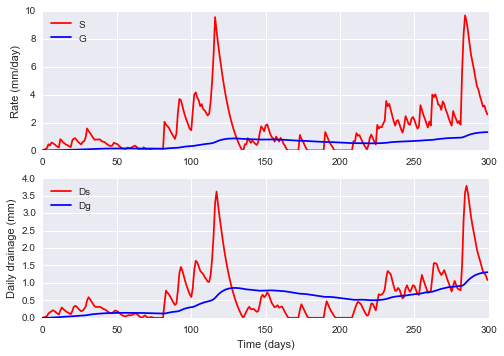

In [43]:
print 'Runtime = %.2f s.' % (t2 - t1)

# Plot
df = pd.DataFrame(data=np.vstack(data), columns=['S', 'G', 'Ds', 'Dg'])

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(df.index, df['S'], 'r-', label='S')
axes[0].plot(df.index, df['G'], 'b-', label='G')
axes[0].set_ylabel('Rate (mm/day)')
axes[0].legend(loc='best')

axes[1].plot(df.index, df['Ds'], 'r-', label='Ds')
axes[1].plot(df.index, df['Dg'], 'b-', label='Dg')
axes[1].set_ylabel('Daily drainage (mm)')
axes[1].set_xlabel('Time (days)')
axes[1].legend(loc='best')

plt.show()

This seems to work pretty well, but it's quite cumbersome and could become difficult to work with for more complex systems. It's also worth noting that the performance is strongly influenced by the choice of solver. `odespy` has lots of different solver methods available:

In [44]:
methods = odespy.list_available_solvers()
for method in methods:
    print method

AdamsBashMoulton2
AdamsBashMoulton3
AdamsBashforth2
AdamsBashforth3
AdamsBashforth4
Backward2Step
BackwardEuler
BogackiShampine
CashKarp
CrankNicolson
Dop853
Dopri5
DormandPrince
Euler
EulerCromer
Fehlberg
ForwardEuler
Heun
Leapfrog
LeapfrogFiltered
Lsoda
Lsodar
Lsode
Lsodes
Lsodi
Lsodis
Lsoibt
MidpointImplicit
MidpointIter
RK2
RK3
RK4
RKC
RKF45
RKFehlberg
Radau5
Radau5Explicit
Radau5Implicit
RungeKutta1
RungeKutta2
RungeKutta3
RungeKutta4
ThetaRule
Trapezoidal
Vode
lsoda_scipy
odefun_sympy


Of these, `Vode` seems popular and is reasonably fast. `Dopri5` and `Dop853` are also widely used (and I think very stable?), but they are significantly slower. `Lsoda` is marginally faster than `Vode` and the very basic `Euler` scheme is faster still, although I suspect its performance would degrade rapidly for more complex ODE systems.

Some obvious options to change the performance of the above code include:

  1. Changing the **integration time step** (i.e. the separation of the $t_i$). Using fewer segmenst within each time step should improve performance, but at the expense of larger errors in locating the time of threshold crossing "events". <br><br>
  
  2. Change the **solver** used. More sophisticated solvers are presumably more robust, but also slower. I think some solvers are better suited than others to dealing with e.g. "[stiff](https://en.wikipedia.org/wiki/Stiff_equation)" or strongly non-linear systems. The test system here is so simple that I suspect almost any solver should work OK. This will not be true for more realistic examples. <br><br>
  
  3. Switch the solver ccode to **FORTRAN** or **C**. In some cases, odespy is already calling underlying FORTRAN and C libraries (e.g. `ODEPACK`). In other cases the implementations are written in pure Python. The FORTRAN and C solvers should be faster.
  
## 6. Dynamical systems packages

**[PyDSTool](http://www.ni.gsu.edu/~rclewley/PyDSTool/FrontPage.html)** is a sophisticated-looking Python package for modelling complex dynamic systems. It's capabilities are currently well beyond anything that I need at present, but it looks interesting. In particular, PyDSTool includes "**event detection**" to arbitrary precision, as well as the ability to develop **hybrid models**, which automatically switch from one ODE system to another when a specified event occurs.

### 6.1. Specify the PyDSTool model

In [45]:
# Define ODEs as strings
dS_dt = '(H - S)/T_s'       # Soil outflow rate (mm/day)
dG_dt = '(beta*S - G)/T_g'  # Groundwater outflow rate (mm/day)
dDs_dt = '(1 - beta)*S'     # Accumulated soil drainage to stream (mm)
dDg_dt = 'G'                # Accumulated groundwater drainage to stream (mm)

# Define an "event" for when the soil store dries out
event_args = {'name':'soil_dry',
              'eventtol':1e-6,
              'term':True,
              'active':True}
soil_dry_ev = dst.makeZeroCrossEvent('S',                
                                     -1,    # Only trigger in decreasing S direction
                                     event_args,
                                     varnames=['S'])

# Build model
mod_args = {'pars':{'H':0, 'beta':beta, 'T_s':T_s, 'T_g':T_g},
            'varspecs':{'S':dS_dt, 'G':dG_dt, 'Ds':dDs_dt, 'Dg':dDg_dt},
            'events':soil_dry_ev, # Associate event with this model
            'name':'model'}
model = dst.Generator.Vode_ODEsystem(mod_args)

### 6.2. Loop over time series data

In [46]:
data = []

# Variables to hold values of S and G
S = S0
G = G0

t1 = time.time()

# Loop over met data
for step in range(n_steps):
    # Get H for this step
    H = float(met_df['HER_mm'].ix[step])
    
    # Set H, S and G in wet model
    model.set(pars={'H':H},
              ics={'S':S, 'G':G, 'Ds':0, 'Dg':0},
              tdata=[0, step_len])
    
    # Solve
    traj = model.compute('traj')
    res = traj.sample()[-1] # Get only the last values
    res = np.array([res['S'], res['G'], res['Ds'], res['Dg']])

    # Results can be negative to within small tolerance.
    # Set back to zero
    res[res < 0] = 0
    
    # Check for events
    if model.getEvents()['soil_dry']:
        # Get remaining time in this step
        t_rem = step_len - float(model.getEvents()['soil_dry']['t'])

        # Restart the solver
        model.set(pars={'H':0},
                  ics={'S':0, 'G':res[1]},
                  tdata=[0, t_rem])
        traj = model.compute('traj')
        res2 = traj.sample()[-1]
        res2 = np.array([res2['S'], res2['G'], res2['Ds'], res2['Dg']])
        
        # Update results
        res[1] = res2[1]           # Update G
        res[2] = res[2] + res2[2]  # Ds
        res[3] = res[3] + res2[3]  # Dg 
    
    # Append results
    data.append(res)
    
    # Update initial conditions for next step
    S = res[0]
    G = res[1]

t2 = time.time()    

### 6.3. Plot results

Runtime = 1.92 s.


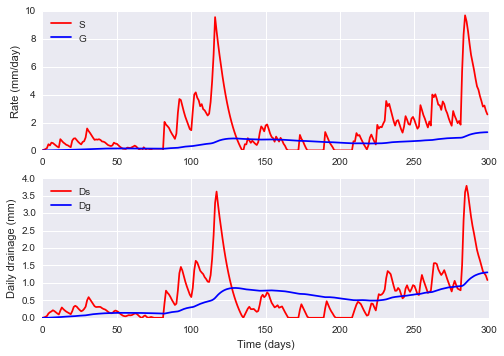

In [47]:
print 'Runtime = %.2f s.' % (t2 - t1)

# Plot
df = pd.DataFrame(data=np.vstack(data), columns=['S', 'G', 'Ds', 'Dg'])

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(df.index, df['S'], 'r-', label='S')
axes[0].plot(df.index, df['G'], 'b-', label='G')
axes[0].set_ylabel('Rate (mm/day)')
axes[0].legend(loc='best')

axes[1].plot(df.index, df['Ds'], 'r-', label='Ds')
axes[1].plot(df.index, df['Dg'], 'b-', label='Dg')
axes[1].set_ylabel('Daily drainage (mm)')
axes[1].set_xlabel('Time (days)')
axes[1].legend(loc='best')

plt.show()

This approach has the advantage of identifying the soil drying event to much greater precision, and it's also (arguably) neater to code. However, it's also **three times slower** than the odespy implementation. As before, PyDSTool has lots of options for abstracting things into e.g. C to make it faster, but I'm not going to delve into optimisation at this stage.